In [ ]:
# Install required libraries
!pip install pandas matplotlib seaborn scikit-learn xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import joblib

In [ ]:
# Load the dataset
train_df = pd.read_csv('/content/drive/MyDrive/CMaps/train_FD001.txt', sep=" ", header=None, engine='python')
test_df = pd.read_csv('/content/drive/MyDrive/CMaps/test_FD001.txt', sep=" ", header=None, engine='python')
rul_df = pd.read_csv('/content/drive/MyDrive/CMaps/RUL_FD001.txt', sep=" ", header=None, engine='python')

# Drop unnecessary columns (spaces in the data file lead to additional columns)
train_df = train_df.dropna(axis=1, how='all')
test_df = test_df.dropna(axis=1, how='all')

# Rename columns
columns = ['engine_no', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]
train_df.columns = columns
test_df.columns = columns

In [ ]:
# Calculate Remaining Useful Life (RUL)
rul = train_df.groupby('engine_no')['time_in_cycles'].max()
train_df['RUL'] = train_df['engine_no'].apply(lambda x: rul[x]) - train_df['time_in_cycles']

# Feature Engineering: Rolling Means, Exponential Moving Averages, etc.
window_size = 5
for sensor in [col for col in train_df.columns if 'sensor' in col]:
    train_df[f'{sensor}_rolling_mean'] = train_df.groupby('engine_no')[sensor].transform(lambda x: x.rolling(window=window_size).mean())
    train_df[f'{sensor}_exp_moving_avg'] = train_df.groupby('engine_no')[sensor].transform(lambda x: x.ewm(span=window_size).mean())

train_df.fillna(0, inplace=True)

In [ ]:
# Prepare the data for training
X_train = train_df.drop(columns=['RUL', 'engine_no', 'time_in_cycles'])
y_train = train_df['RUL']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Save the model
joblib.dump(xgb_model, 'xgb_rul_model.pkl')

['xgb_rul_model.pkl']

In [ ]:
# Predict on the validation set
y_pred = xgb_model.predict(X_val)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 36.88707532189708


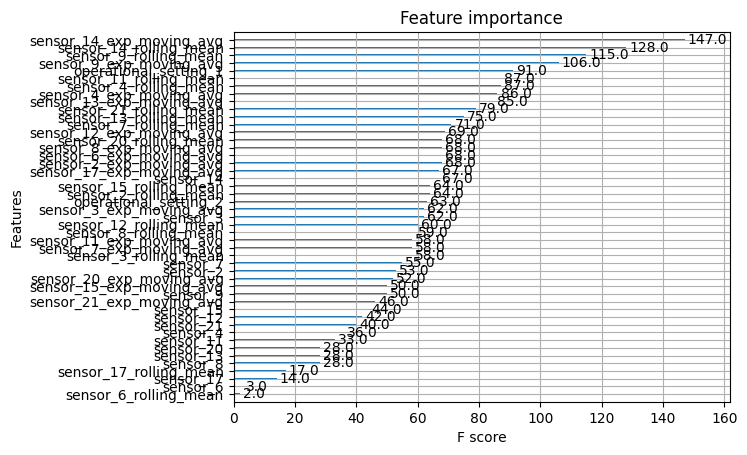

In [ ]:
# Plot feature importance
xgb_model.get_booster().feature_names = X_train.columns.to_list()
xgb.plot_importance(xgb_model)
plt.show()